<a href="https://colab.research.google.com/github/samyak1512/hacktoberfest/blob/master/Rossman_Store_Sales_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import logging
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from lightgbm import LGBMRegressor
from prophet import Prophet
logging.getLogger("cmdstanpy").disabled = True
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from itertools import product

In [3]:
store_details = pd.read_csv("/content/drive/MyDrive/dataset machine learning/rossmann-store-sales/store.csv")

In [4]:
store_details

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [5]:
df = pd.read_csv("/content/drive/MyDrive/dataset machine learning/rossmann-store-sales/train.csv", index_col = "Date", low_memory=False, parse_dates=['Date'])

In [6]:
df = df[df["Store"] == 1]

In [7]:
df = df.asfreq('D')

In [8]:
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

In [9]:
df.sort_values(by="Date", inplace=True)

In [10]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size].copy(deep=True)
test_data = df[train_size:].copy(deep=True)

In [11]:
import plotly.express as px

In [12]:
# prompt: create line chart using plotly

fig = px.line(train_data, y="Sales", title="Daily Sales Trend for Store 1")
fig.show()


In [13]:
fig = px.line(train_data[:30], y="Sales", title="Monthly Sales Trend for Store 1")
fig.show()

In [14]:
fig = px.line(train_data[:365], y="Sales", title="Monthly Sales Trend for Store 1")
fig.show()

In [15]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

# Convert the columns to integers
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

In [16]:
# prompt: create line chart using plotly of store_1 and sales but only for 1 week

store_1_week = train_data.iloc[:7, :]
fig = px.line(store_1_week,y="Sales", title="Daily Sales Trend for Store 1 (First Week)")
fig.show()


In [17]:
# prompt: create line chart using plotly of store_1 and sales but only for 2nd week

store_1_week2 = train_data.iloc[7:14, :]
fig = px.line(store_1_week2, y="Sales", title="Daily Sales Trend for Store 1 (Second Week)")
fig.show()


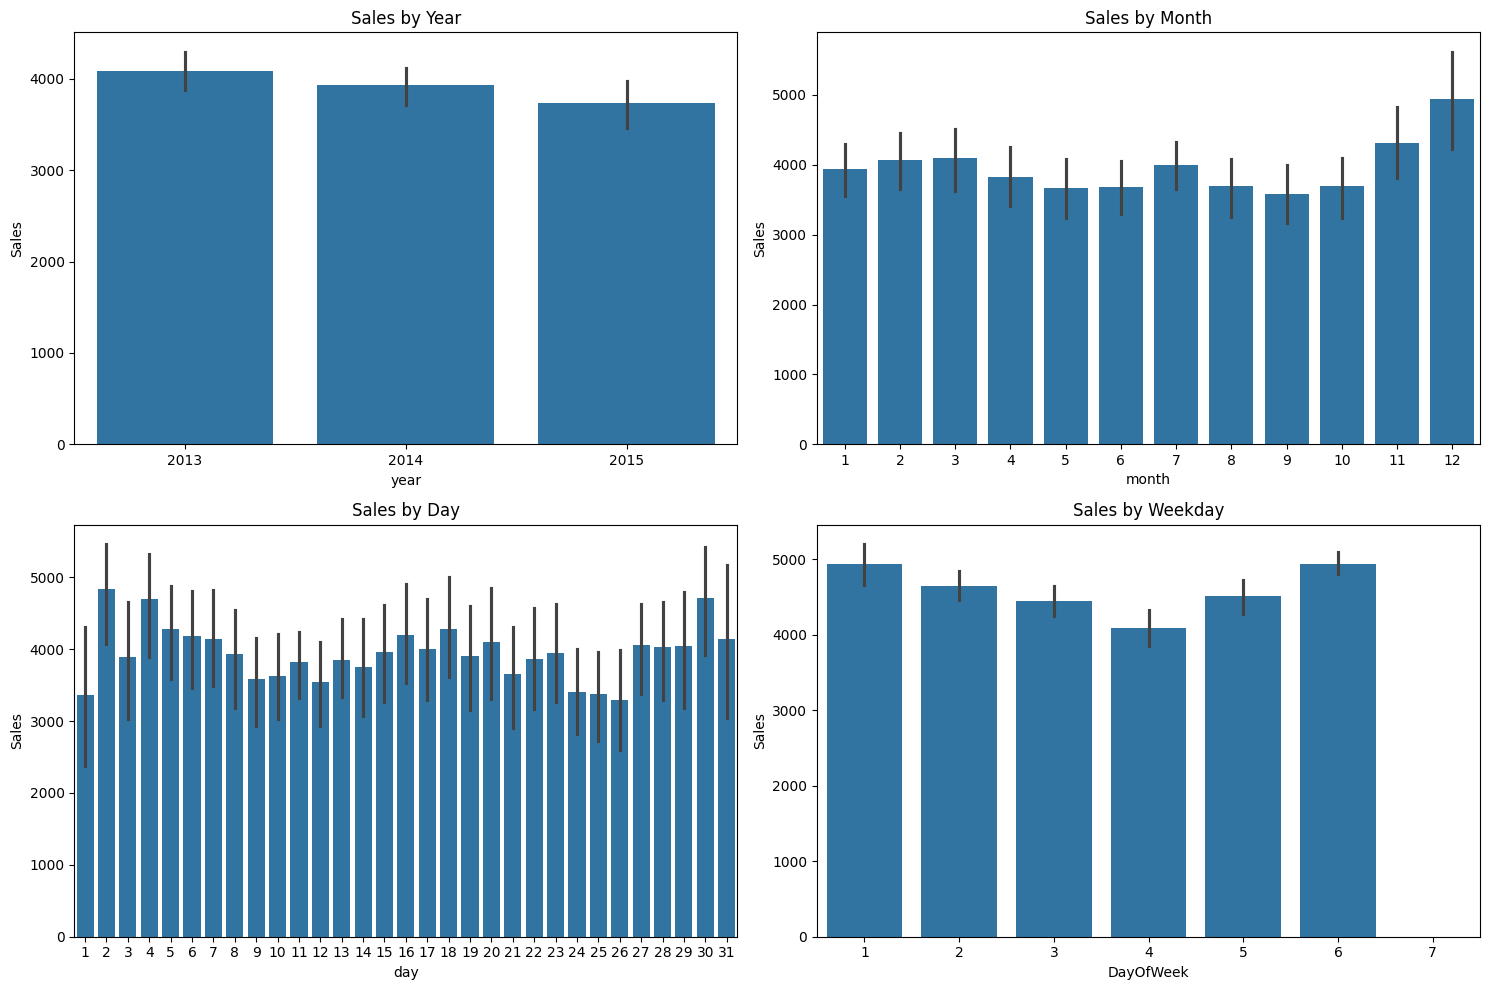

In [18]:
# Create a grid of bar charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(x='year',y="Sales", data=df, ax=axes[0, 0])
sns.barplot(x='month',y="Sales", data=df, ax=axes[0, 1])
sns.barplot(x='day',y="Sales", data=df, ax=axes[1, 0])
sns.barplot(x='DayOfWeek',y="Sales", data=df, ax=axes[1, 1])

# Set the titles for each chart
axes[0, 0].set_title('Sales by Year')
axes[0, 1].set_title('Sales by Month')
axes[1, 0].set_title('Sales by Day')
axes[1, 1].set_title('Sales by Weekday')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of bar charts
plt.show()

In [19]:
def monthly_quarter_line_plot(df,col_x,col_y,hue_col,title="Monthly"):
    plt.figure(figsize=(10,8))
    sns.lineplot(data=train_data,
                 x=col_x,
                 y=col_y,
                 hue=hue_col,
                 palette="tab10")

    # add title
    plt.title(title+' Seasonal plot')


In [20]:
# prompt: apply one hot encoding on state holiday on dataset store_1

import pandas as pd
df = pd.get_dummies(df, columns=["StateHoliday"])
df = pd.get_dummies(df, columns=["DayOfWeek"])
# df = pd.get_dummies(df, columns = ["Store"])



In [21]:
df

,Store,Sales,Customers,Open,Promo,SchoolHoliday,year,month,day,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,1,2013,1,1,False,True,False,False,False,True,False,False,False,False,False
2013-01-02,1,5530,668,1,0,1,2013,1,2,True,False,False,False,False,False,True,False,False,False,False
2013-01-03,1,4327,578,1,0,1,2013,1,3,True,False,False,False,False,False,False,True,False,False,False
2013-01-04,1,4486,619,1,0,1,2013,1,4,True,False,False,False,False,False,False,False,True,False,False
2013-01-05,1,4997,635,1,0,1,2013,1,5,True,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,6102,612,1,1,1,2015,7,27,True,False,False,False,True,False,False,False,False,False,False
2015-07-28,1,5011,560,1,1,1,2015,7,28,True,False,False,False,False,True,False,False,False,False,False
2015-07-29,1,4782,523,1,1,1,2015,7,29,True,False,False,False,False,False,True,False,False,False,False


In [22]:
df# prompt: drop store column from df

# df = df.drop(columns=["Store"])
df= df.drop(columns = ["SchoolHoliday"])


In [23]:
df

,Store,Sales,Customers,Open,Promo,year,month,day,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,2013,1,1,False,True,False,False,False,True,False,False,False,False,False
2013-01-02,1,5530,668,1,0,2013,1,2,True,False,False,False,False,False,True,False,False,False,False
2013-01-03,1,4327,578,1,0,2013,1,3,True,False,False,False,False,False,False,True,False,False,False
2013-01-04,1,4486,619,1,0,2013,1,4,True,False,False,False,False,False,False,False,True,False,False
2013-01-05,1,4997,635,1,0,2013,1,5,True,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,6102,612,1,1,2015,7,27,True,False,False,False,True,False,False,False,False,False,False
2015-07-28,1,5011,560,1,1,2015,7,28,True,False,False,False,False,True,False,False,False,False,False
2015-07-29,1,4782,523,1,1,2015,7,29,True,False,False,False,False,False,True,False,False,False,False


In [24]:
# prompt: Using dataframe train_data: prepare a correlation matrix in plotly

import pandas as pd
import plotly.express as px

# Create a correlation matrix
correlation_matrix = df.corr()

# Generate a heatmap using plotly express
fig = px.imshow(correlation_matrix,
              x=correlation_matrix.columns,
              y=correlation_matrix.index,
              color_continuous_scale='Viridis',
              text_auto=True,
                aspect="auto")

# Update the layout
fig.update_layout(
    title='Correlation Matrix of Train Data',
    xaxis_title='Features',
    yaxis_title='Features'
)

# Show the plot
fig.show()

In [25]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

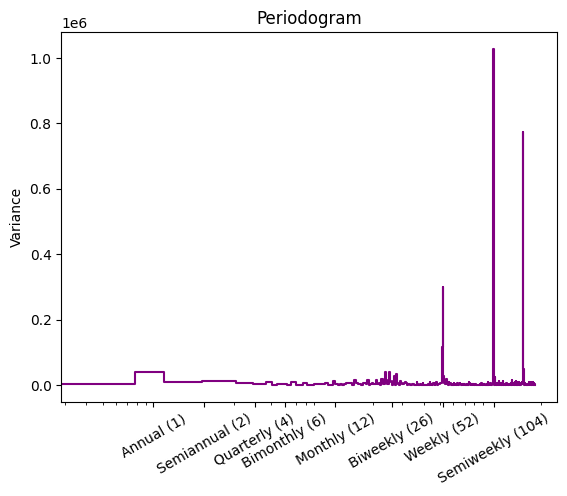

In [26]:
plot_periodogram(df.Sales);

In [27]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=24)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in df.index

In [28]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(20,freq=A-DEC)","cos(20,freq=A-DEC)","sin(21,freq=A-DEC)","cos(21,freq=A-DEC)","sin(22,freq=A-DEC)","cos(22,freq=A-DEC)","sin(23,freq=A-DEC)","cos(23,freq=A-DEC)","sin(24,freq=A-DEC)","cos(24,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.337523,0.941317,0.353676,0.935368,0.369725,0.929141,0.385663,0.922640,0.401488,0.915864
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.635432,0.772157,0.661635,0.749826,0.687053,0.726608,0.711657,0.702527,0.735417,0.677615
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.858764,0.512371,0.884068,0.467359,0.907014,0.421101,0.927542,0.373720,0.945596,0.325342
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.981306,0.192452,0.992222,0.124479,0.998435,0.055917,0.999917,-0.012910,0.996659,-0.081676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1.0,938.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.409356,-0.912375,...,0.835925,-0.548843,-0.538005,0.842942,0.145799,-0.989314,0.271958,0.962309,-0.642055,-0.766659
2015-07-28,1.0,939.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.425000,-0.905193,...,0.601624,-0.798779,-0.205104,0.978740,-0.230306,-0.973118,0.622047,0.782980,-0.895839,-0.444378
2015-07-29,1.0,940.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.440519,-0.897743,...,0.296713,-0.954967,0.154309,0.988023,-0.573772,-0.819015,0.875892,0.482508,-0.998880,-0.047321


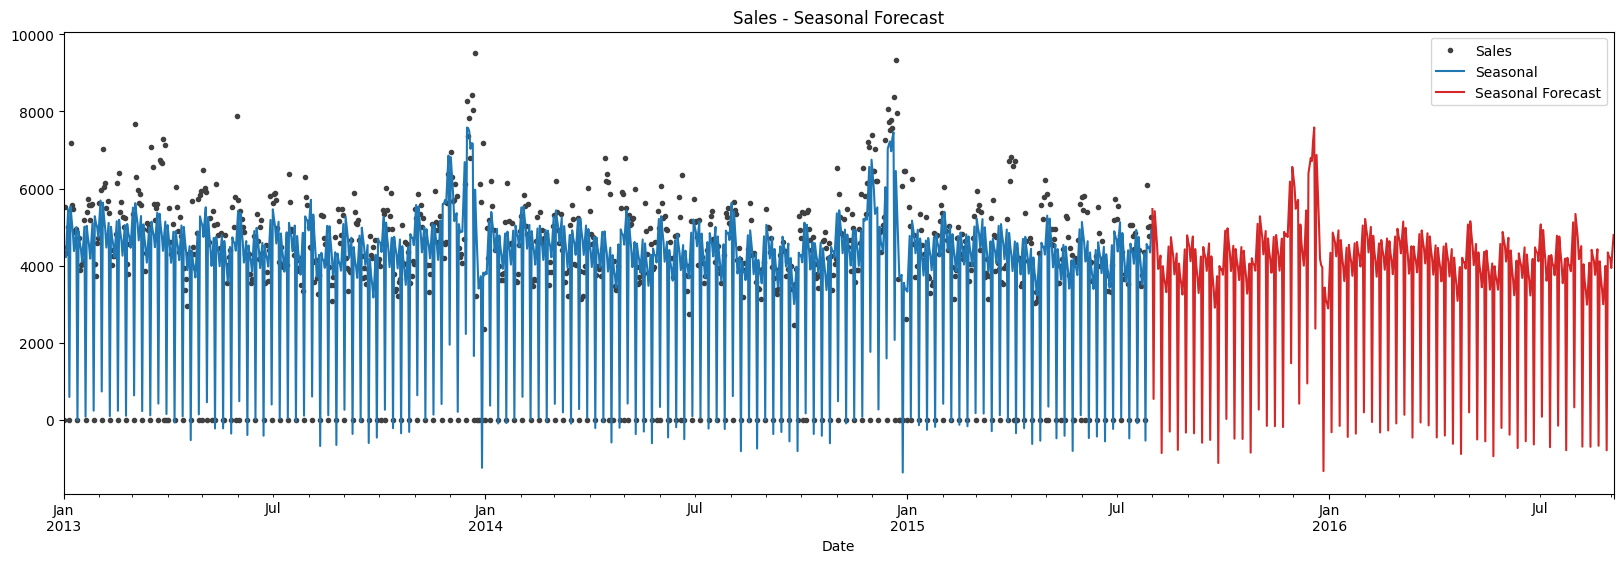

In [29]:
y = df["Sales"]
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=400)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Sales - Seasonal Forecast", figsize=(20, 6))
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [30]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


In [31]:
X = df.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.isocalendar().week
X["week"] = X["week"].astype("int64")  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Freq: D
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Store           942 non-null    int64
 1   Sales           942 non-null    int64
 2   Customers       942 non-null    int64
 3   Open            942 non-null    int64
 4   Promo           942 non-null    int64
 5   year            942 non-null    int32
 6   month           942 non-null    int64
 7   day             942 non-null    int32
 8   StateHoliday_0  942 non-null    bool 
 9   StateHoliday_a  942 non-null    bool 
 10  StateHoliday_b  942 non-null    bool 
 11  StateHoliday_c  942 non-null    bool 
 12  DayOfWeek_1     942 non-null    bool 
 13  DayOfWeek_2     942 non-null    bool 
 14  DayOfWeek_3     942 non-null    bool 
 15  DayOfWeek_4     942 non-null    bool 
 16  DayOfWeek_5     942 non-null    bool 
 17  DayOfWeek_6     942 non-null    bool 
 18  Day

<ipython-input-30-dce485a0e5ca>:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.


<ipython-input-30-dce485a0e5ca>:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




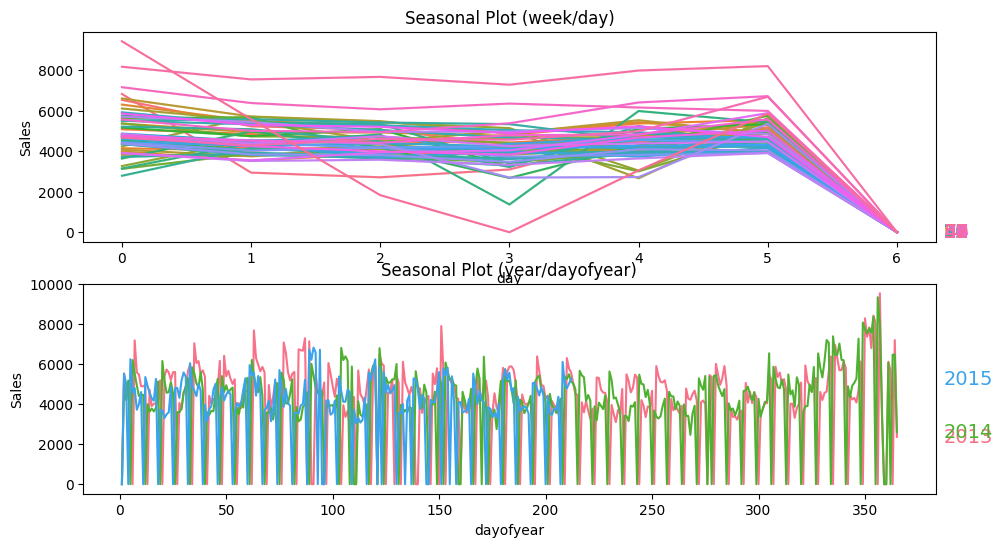

In [33]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
# seasonal_plot(X, y="Sales", period="week", freq="day", ax=ax0)
(seasonal_plot(X, y="Sales", period="week", freq="day", ax = ax0))
seasonal_plot(X, y="Sales", period="year", freq="dayofyear", ax=ax1);

In [34]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

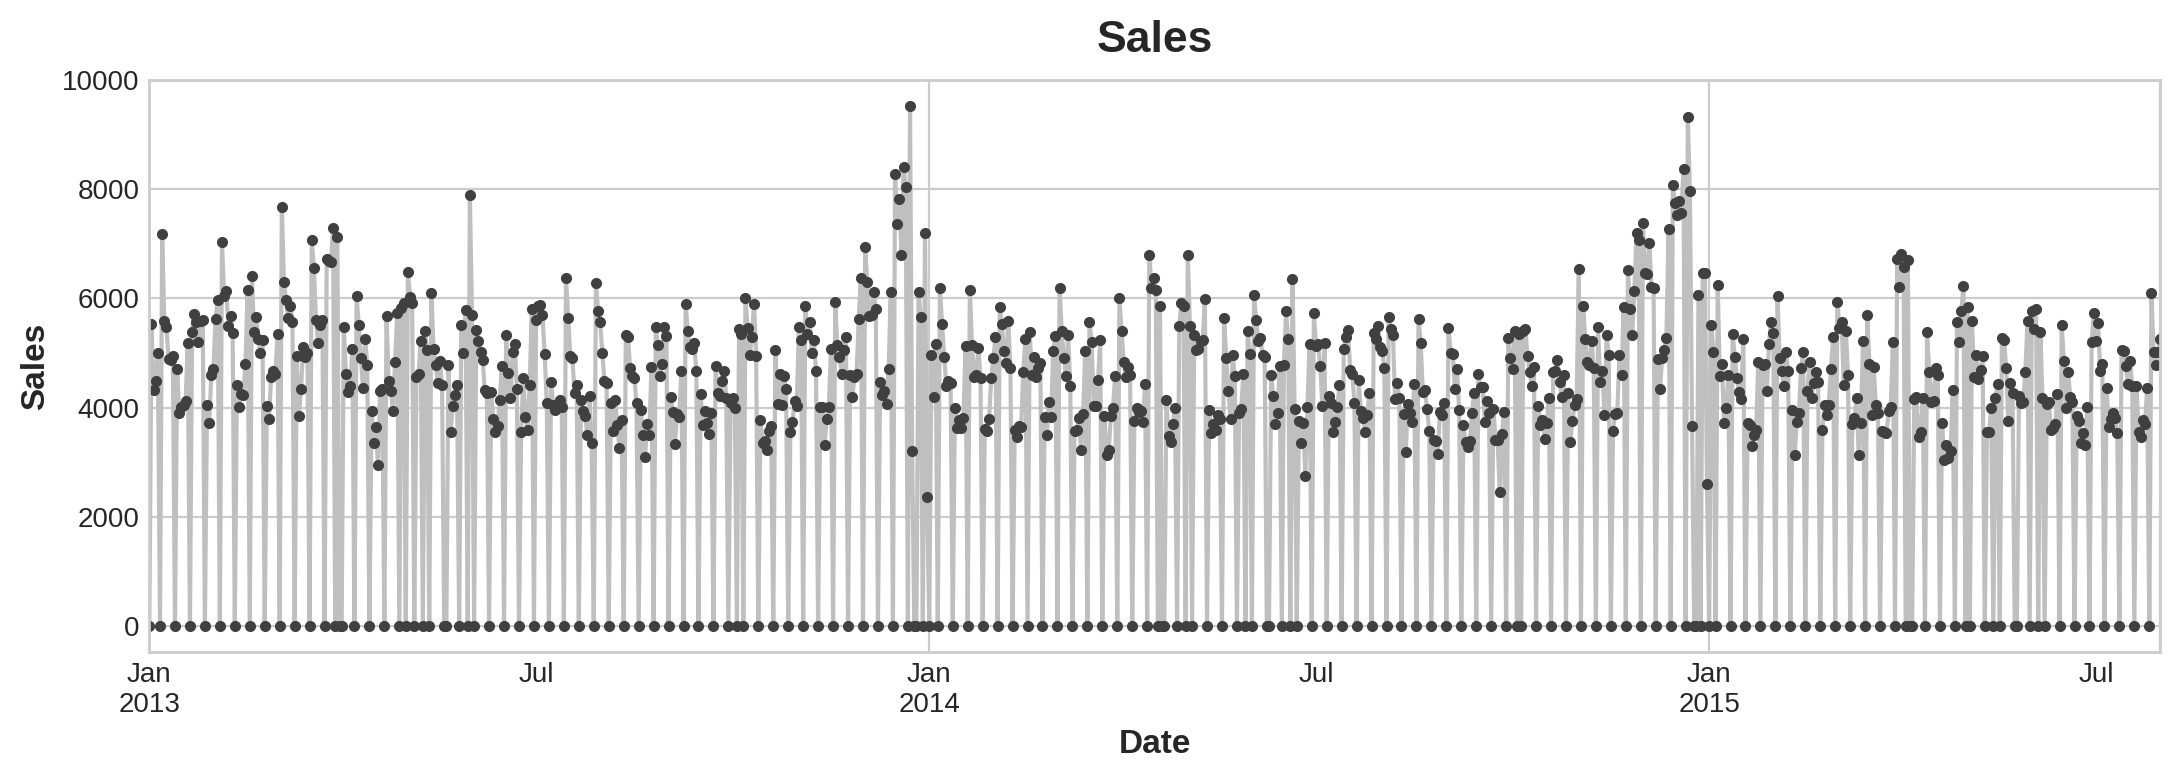

In [35]:

ax = df.Sales.plot(title='Sales', **plot_params)
_ = ax.set(ylabel="Sales")

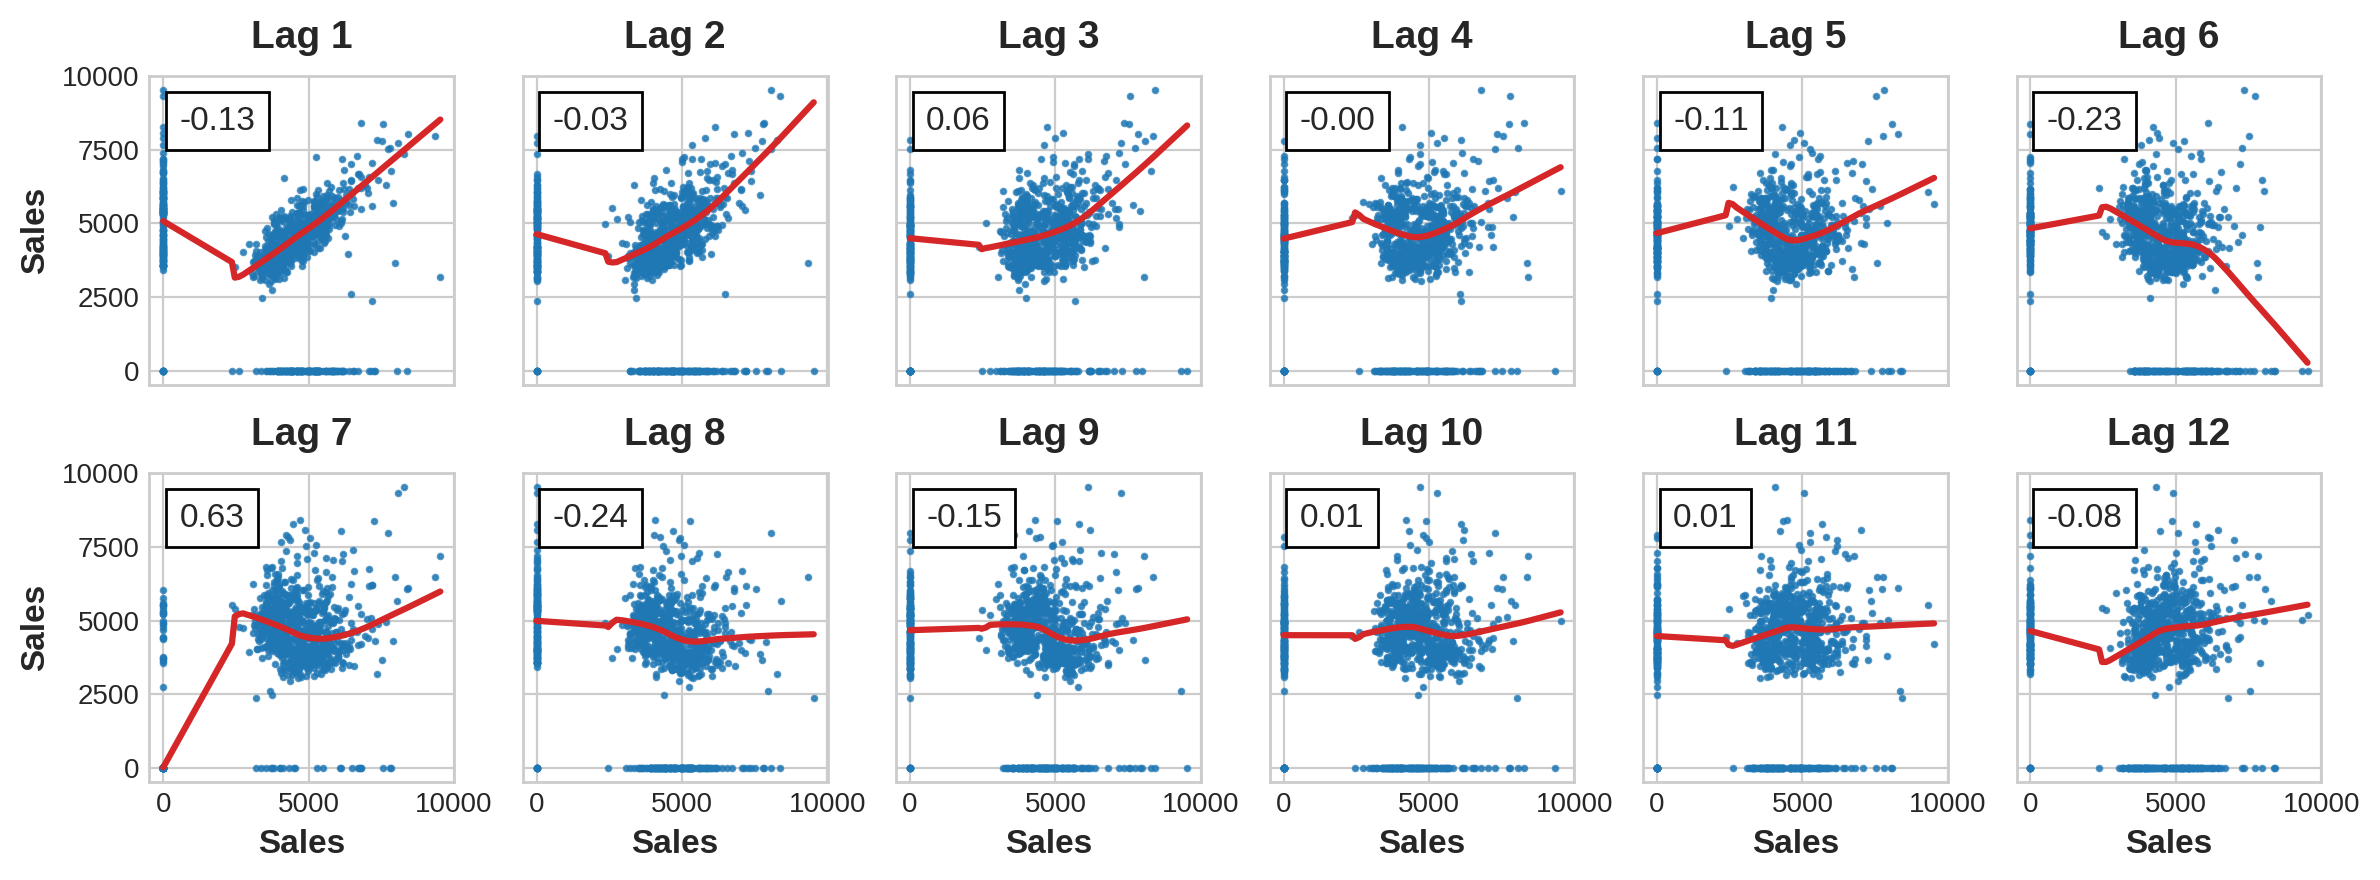

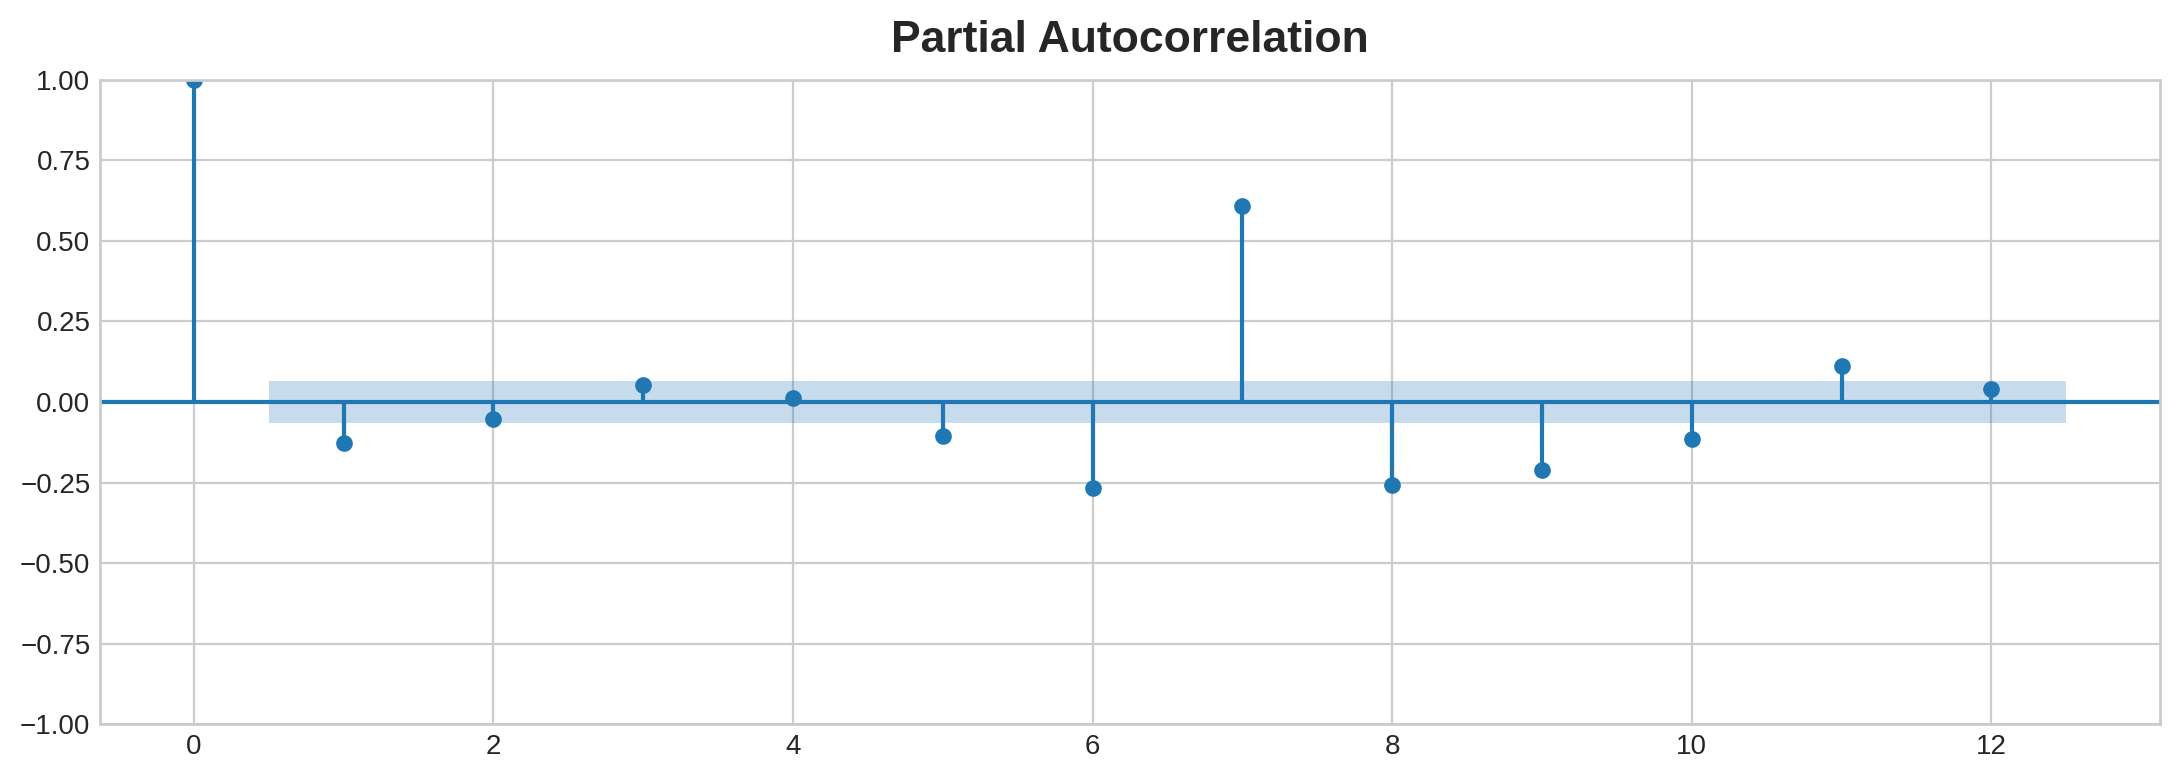

In [36]:
_ = plot_lags(df.Sales, lags=12, nrows=2)
print()
_ = plot_pacf(df.Sales, lags=12)

In [37]:
df

,Store,Sales,Customers,Open,Promo,year,month,day,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,2013,1,1,False,True,False,False,False,True,False,False,False,False,False
2013-01-02,1,5530,668,1,0,2013,1,2,True,False,False,False,False,False,True,False,False,False,False
2013-01-03,1,4327,578,1,0,2013,1,3,True,False,False,False,False,False,False,True,False,False,False
2013-01-04,1,4486,619,1,0,2013,1,4,True,False,False,False,False,False,False,False,True,False,False
2013-01-05,1,4997,635,1,0,2013,1,5,True,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,6102,612,1,1,2015,7,27,True,False,False,False,True,False,False,False,False,False,False
2015-07-28,1,5011,560,1,1,2015,7,28,True,False,False,False,False,True,False,False,False,False,False
2015-07-29,1,4782,523,1,1,2015,7,29,True,False,False,False,False,False,True,False,False,False,False


In [38]:
def make_specific_lags(df, column, lags):
    lagged_data = pd.concat(
        {
            f'{column}_lag_{i}': df[column].shift(i)
            for i in lags
        },
        axis=1
    )
    return pd.concat([df, lagged_data], axis=1)



X = make_specific_lags(df,'Sales',  [5, 6, 7, 8,9])
X  = X.fillna(0.0)

In [39]:
df

,Store,Sales,Customers,Open,Promo,year,month,day,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
Date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,2013,1,1,False,True,False,False,False,True,False,False,False,False,False
2013-01-02,1,5530,668,1,0,2013,1,2,True,False,False,False,False,False,True,False,False,False,False
2013-01-03,1,4327,578,1,0,2013,1,3,True,False,False,False,False,False,False,True,False,False,False
2013-01-04,1,4486,619,1,0,2013,1,4,True,False,False,False,False,False,False,False,True,False,False
2013-01-05,1,4997,635,1,0,2013,1,5,True,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,6102,612,1,1,2015,7,27,True,False,False,False,True,False,False,False,False,False,False
2015-07-28,1,5011,560,1,1,2015,7,28,True,False,False,False,False,True,False,False,False,False,False
2015-07-29,1,4782,523,1,1,2015,7,29,True,False,False,False,False,False,True,False,False,False,False


In [40]:
X

,Store,Sales,Customers,Open,Promo,year,month,day,StateHoliday_0,StateHoliday_a,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,Sales_lag_5,Sales_lag_6,Sales_lag_7,Sales_lag_8,Sales_lag_9
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,2013,1,1,False,True,...,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0
2013-01-02,1,5530,668,1,0,2013,1,2,True,False,...,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0
2013-01-03,1,4327,578,1,0,2013,1,3,True,False,...,False,True,False,False,False,0.0,0.0,0.0,0.0,0.0
2013-01-04,1,4486,619,1,0,2013,1,4,True,False,...,False,False,True,False,False,0.0,0.0,0.0,0.0,0.0
2013-01-05,1,4997,635,1,0,2013,1,5,True,False,...,False,False,False,True,False,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,6102,612,1,1,2015,7,27,True,False,...,False,False,False,False,False,3464.0,3558.0,4395.0,0.0,4406.0
2015-07-28,1,5011,560,1,1,2015,7,28,True,False,...,False,False,False,False,False,3769.0,3464.0,3558.0,4395.0,0.0
2015-07-29,1,4782,523,1,1,2015,7,29,True,False,...,True,False,False,False,False,3706.0,3769.0,3464.0,3558.0,4395.0


In [41]:
# Create target series and data splits
y = df.Sales.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

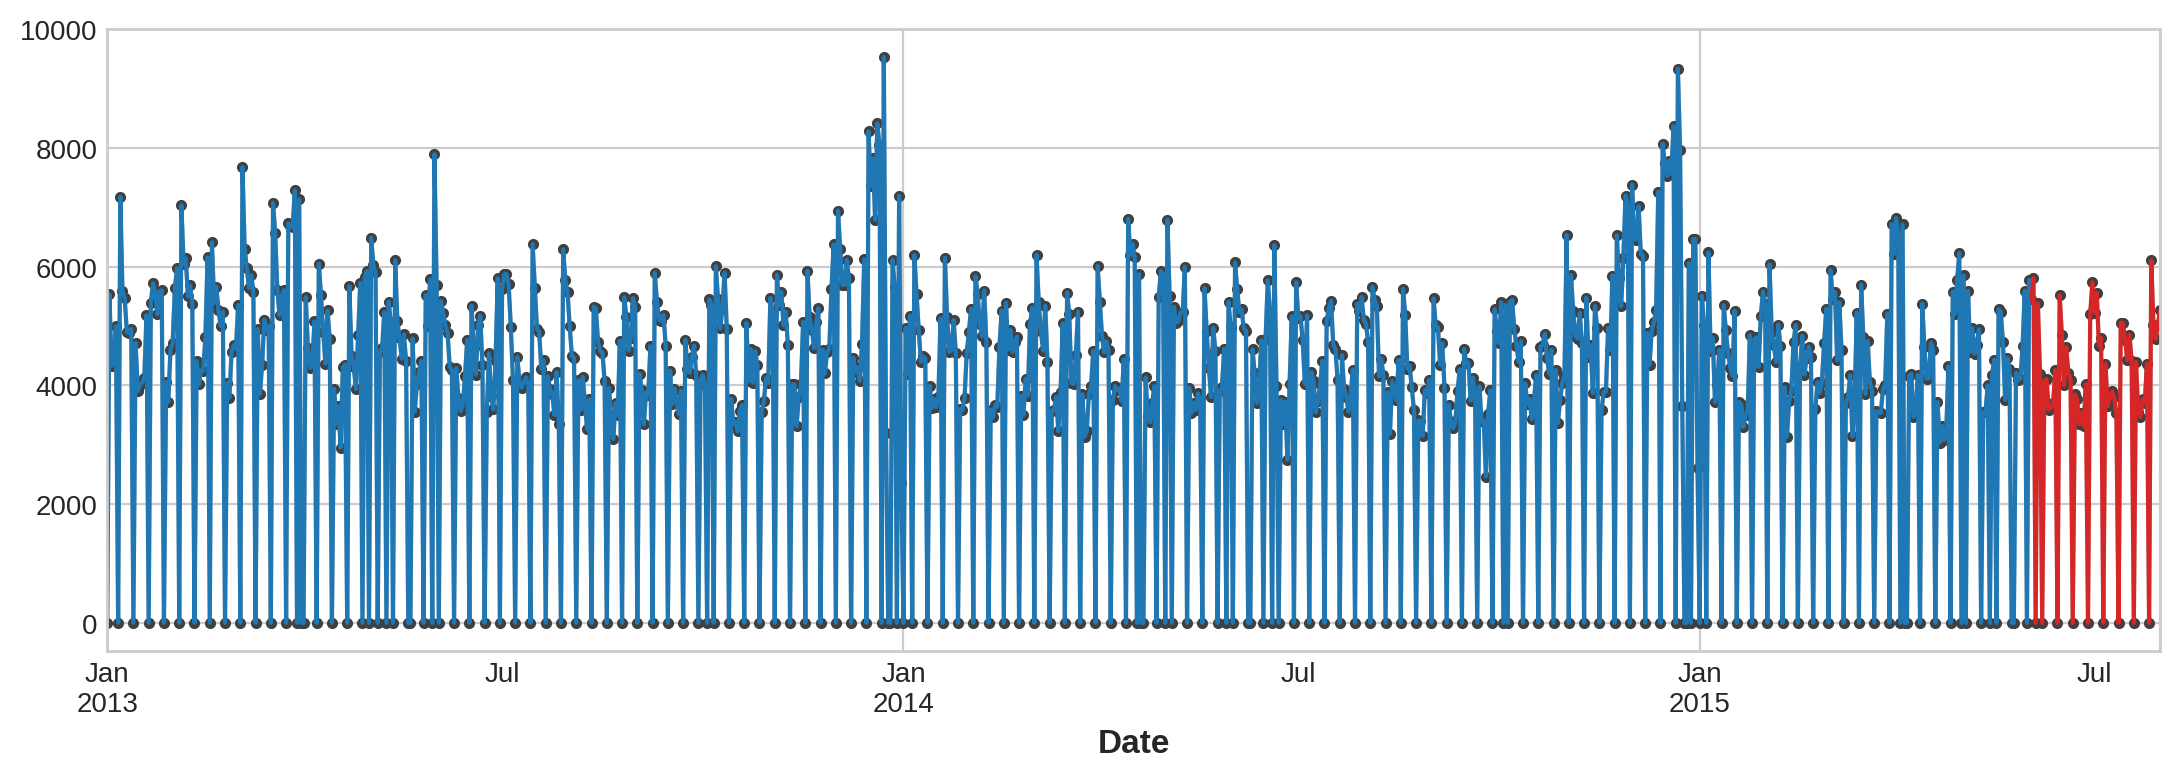

In [42]:
x = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

In [43]:
# prompt: calc error in terms of RMSPE

from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(predicted, actual):
  return np.sqrt(mean_squared_error(predicted, actual))

y_pred = model.predict(X_test)
error = rmse(y_pred, y_test)

print("Root Mean Squared Error:", error)


Root Mean Squared Error: 2.3461203514715784e-12


In [44]:
test_data = pd.read_csv("/content/drive/MyDrive/dataset machine learning/rossmann-store-sales/test.csv")

In [45]:
test_data

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
